In [56]:
!git clone https://github.com/marcin119a/lstm-pycbc.git
%cd lstm-pycbc

Cloning into 'lstm-pycbc'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 236 (delta 33), reused 60 (delta 21), pack-reused 163
Receiving objects: 100% (236/236), 10.80 MiB | 8.97 MiB/s, done.
Resolving deltas: 100% (111/111), done.
/home/marcin119a/lstm-pycbc/lstm-pycbc/lstm-pycbc/lstm-pycbc


In [58]:
%%capture
!pip install -r requirements.txt

In [59]:
!python dump_dataset.py -m1=10 -m2=20 -n=100 -time_steps=300 -quark=True

2020-09-25 09:57:22.634453: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [76]:
import hickle as hkl


array_hkl = hkl.load('/home/marcin119a/lstm-pycbc/data/D-SET(100,1400).hkl')
X_train = array_hkl.get('xtrain')
X_test = array_hkl.get('xtest')
y_train = array_hkl.get('ytrain')
y_test = array_hkl.get('ytest')

In [67]:
X_train.shape

(67, 1400)

In [68]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

In [69]:
X_train.shape

(67, 1400, 1)

In [77]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1], 1)

In [53]:
X_train.shape

(67, 1400, 1)

In [54]:
y_train.shape

(67, 2)

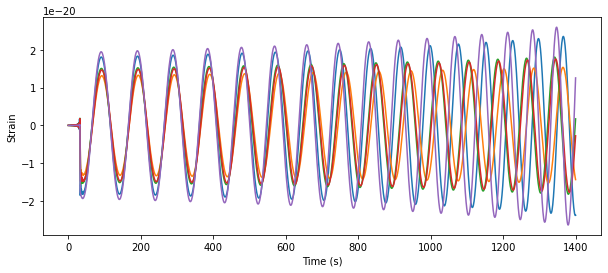

In [71]:
import pylab 
pylab.figure(figsize=(10,4))
for x in range(0,5):
  pylab.plot(X_train[x])
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.show()

In [72]:
from keras.initializers import glorot_normal
from keras.regularizers import l1,l2
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

def create_model(activation='tanh', lr=1e-3, reg=0.0, dropout=0.0):
    """
    Return a neural network model given the hyperparameters.
    """
    n_steps_in, n_steps_out = X_train.shape[1], 1
    n_features = 1

    model = Sequential()
    model.add(LSTM(32,
                   input_shape          = (None, 1),
                   activation           = activation,
                   kernel_regularizer   = l2(reg),
                   kernel_initializer   = glorot_normal(),
                   bias_initializer     = 'ones',
                   dropout              = dropout,
                   name                 = 'ONE',
                   return_sequences     = True)
    )
    model.add(LSTM(32, 
                   activation           = activation))
    model.add(Dense(n_steps_out,
                    activation          = activation,
                    kernel_regularizer  = l2(reg),
                    kernel_initializer  = glorot_normal(),
                    name                = 'TWO'))
    model.compile(optimizer='adam', loss='mse')

    return model

In [63]:
X_train.shape

(67, 1, 300)

In [78]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import numpy as np

space = {
    'activation':hp.choice('activation', ('relu', 'tanh')),
    'lr':hp.loguniform('lr', np.log(1e-6), np.log(1e-2)), 
    'reg':hp.uniform('reg', 1e-6, 1e-3)
}

# define loss function
def loss(params):
    
    model = create_model(**params)

    _ = model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=0)
    val_loss = model.evaluate(X_test, y_test, verbose=1)
    print('Loss: {}'.format(val_loss))
    
    return {'loss':val_loss, 'status':STATUS_OK}

In [ ]:
print('Begin tuning')
print('------------')
trials = Trials()
best_params = fmin(loss,
                   space = space,
                   algo = tpe.suggest,
                   max_evals = 20,
                   trials = trials)
print('')
print('Best parameters:')
print('----------------')
best_params['activation'] = ['relu', 'tanh'][best_params['activation']]
for k, v in best_params.items():
    print('{} = {}'.format(k, v))

In [68]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import keras.optimizers as optim
from keras.regularizers import l1,l2

def create_model(activation='tanh', lr=1e-3, reg=0.0, dropout=0.0):
  n_steps_in, n_steps_out = X_train.shape[1], 1
  n_features = 1
  model = Sequential()
  model.add(LSTM(200, activation=activation, dropout = dropout, kernel_regularizer = l2(reg), return_sequences=True, batch_input_shape=(None, n_steps_in, n_features)))
  model.add(LSTM(200, activation=activation, dropout = dropout, kernel_regularizer = l2(reg)))
  model.add(Dense(n_steps_out, kernel_regularizer = l2(reg)))
  model.compile(optimizer='adam', loss='mse')
  
  return model